In [1]:
# from pm4py.objects.log.importer.xes import importer as xes_importer
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, trange
import datetime
import random
import time
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing as pre
from sklearn import tree
import matplotlib.pyplot as plt
from collections import Counter

### Since the data is already converted, I markdowned the cell below. Remember to de-markdown it before submission

#XES TO CSV
xesToCsv_BPI = xes_importer.apply("Datasets/BPI_Challenge_2012.xes")

xesToCsv_listo = []
xesToCsv_dic = {'no': -1}
xesToCsv_prev_attr = 'no'
xesToCsv_counter = 0
xesToCsv_cur_attr = 'no'

for i in tqdm(range(0, len(xesToCsv_BPI))):

    for j in range(0, len(xesToCsv_BPI[i])):
        xesToCsv_attr_list = list(xesToCsv_BPI[i][j])
    
        for k in range(0, len(xesToCsv_attr_list)):
            xesToCsv_prev_attr = xesToCsv_cur_attr
            xesToCsv_cur_attr = xesToCsv_attr_list[k]

            if xesToCsv_cur_attr not in xesToCsv_listo:
                xesToCsv_value = xesToCsv_dic[xesToCsv_prev_attr] + 1
            
                for key in xesToCsv_dic:
                    if xesToCsv_dic[key] >= xesToCsv_value:
                        xesToCsv_dic[key] += 1
            
                xesToCsv_dic[xesToCsv_cur_attr] = xesToCsv_value
                xesToCsv_listo.insert(xesToCsv_value, xesToCsv_cur_attr)
        
        xesToCsv_cur_attr = 'no'
        
        
xesToCsv_chain = []
xesToCsv_event = []

for i in tqdm(range(0, len(xesToCsv_BPI))):
    for j in range(0, len(xesToCsv_BPI[i])):
        xesToCsv_chain.append(i)
        xesToCsv_event.append(j)
        
xesToCsv_df_BPI= pd.DataFrame(index=[np.array(xesToCsv_chain), np.array(xesToCsv_event)], columns = xesToCsv_listo)

for i in tqdm(range(0, len(xesToCsv_BPI))):
    
    for j in range(0, len(xesToCsv_BPI[i])):

        xesToCsv_attr = xesToCsv_BPI[i][j]
        
        for a in xesToCsv_attr:
            xesToCsv_df_BPI.loc[(i, j), a] = xesToCsv_attr[a]
            
            
xesToCsv_df_BPI.to_csv('Datasets/BPI_2012.csv')

xesToCsv_attr_listo = []
xesToCsv_attr_dic = {'no': -1}
xesToCsv_prev_attr = 'no'
xesToCsv_counter = 0
xesToCsv_cur_attr = 'no'

for i in tqdm(range(0, len(xesToCsv_BPI))):
    xesToCsv_attr_list = list(xesToCsv_BPI[i].attributes)
    
    for k in range(0, len(xesToCsv_attr_list)):
        xesToCsv_prev_attr = xesToCsv_cur_attr
        xesToCsv_cur_attr = xesToCsv_attr_list[k]

        if xesToCsv_cur_attr not in xesToCsv_attr_listo:
            xesToCsv_value = xesToCsv_attr_dic[xesToCsv_prev_attr] + 1
            
            for key in xesToCsv_attr_dic:
                if xesToCsv_attr_dic[key] >= xesToCsv_value:
                    xesToCsv_attr_dic[key] += 1
            
            xesToCsv_attr_dic[xesToCsv_cur_attr] = xesToCsv_value
            xesToCsv_attr_listo.insert(xesToCsv_value, xesToCsv_cur_attr)
    
    xesToCsv_cur_attr = 'no'
    
    
xesToCsv_attr_chain = []

for i in tqdm(range(0, len(xesToCsv_BPI))):
    xesToCsv_attr_chain.append(i)
    

xesToCsv_df_BPI_attr = pd.DataFrame(index = [np.array(xesToCsv_attr_chain)], columns = xesToCsv_attr_listo)


for i in tqdm(range(0, len(xesToCsv_BPI))):

    xesToCsv_attr = xesToCsv_BPI[i].attributes
    
    for a in xesToCsv_attr:
        xesToCsv_df_BPI_attr.loc[i, a] = xesToCsv_attr[a]
        
xesToCsv_df_BPI_attr.to_csv('Datasets/BPI_attr_2012.csv')

if 'Unnamed: 0' in xesToCsv_df_BPI.columns:
    xesToCsv_df_BPI = xesToCsv_df_BPI.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
    xesToCsv_df_BPI_attr = xesToCsv_df_BPI_attr.rename(columns={'Unnamed: 0': 'case_id'})

## Data loading:

Loads the data with some safety-features for common mishaps we had

In [17]:
def fix_time(time):
    return (datetime.datetime.fromisoformat(time))

def load_data(BPI = 'BPI.csv', BPI_attr = 'BPI_attr.csv',  data2012 = False):
    df_BPI = pd.read_csv(BPI)
    df_BPI_attr = pd.read_csv(BPI_attr)
    
    if 'Unnamed: 0' in df_BPI.columns:
        df_BPI = df_BPI.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
        df_BPI_attr = df_BPI_attr.rename(columns={'Unnamed: 0': 'case_id'})
    
    df_BPI['time:timestamp'] = df_BPI['time:timestamp'].apply(fix_time)

    if data2012:
        df_BPI_attr['REG_DATE'] = df_BPI_attr['REG_DATE'].apply(fix_time)
    
    df_BPI['time:weekday'] = [x.weekday() for x in df_BPI['time:timestamp']]
    df_BPI['time:hour'] = [x.hour for x in df_BPI['time:timestamp']]
    return (df_BPI, df_BPI_attr)

def load_data_xes(data):
    BPI = xes_importer.apply(data)

In [ ]:
df, df_attr = load_data(BPI = 'Datasets/BPI_2012.csv', BPI_attr = 'Datasets/BPI_attr_2012.csv', data2012 = True)
df

## Data splitting:

The bellow code splits the data and saves it. This code takes around 9 minutes to run. Thus we have added the pre-split data to the zip file, which can be loaded in the next part.

In [ ]:
def data_split(df : pd.DataFrame, amount_train_data = 0.8, amount_validation_data = 0.2) -> tuple:
    '''Plug in the df and train and validation data percentages'''
    
    splitData_df = df.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
    splitData_df_attr = df_attr.rename(columns={'Unnamed: 0': 'case_id'})
    
    splitData_limit_date = splitData_df[splitData_df['case_id'] 
    == round(splitData_df.iloc[-1, 0]*amount_train_data)].iloc[0]['time:timestamp']
    #splitData_limit_date = datetime.datetime(2012, 2, 3, 1, 1, 1, 633000, 
                                         #tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))

    #training data_set
    splitData_df_train = splitData_df
    splitData_listo = []

    for i in tqdm(range(0, 13087)):
        if splitData_df[splitData_df['case_id'] == i].iloc[-1]['time:timestamp'] > splitData_limit_date:
            splitData_listo.append(i)

    for i in tqdm(range(0, len(splitData_listo))):
        splitData_df_train = splitData_df_train.drop(splitData_df_train[splitData_df_train['case_id'] == splitData_listo[i]].index)

    splitData_df_train = splitData_df_train.reset_index(drop = True)
    
    #validation data_set
    mask = np.random.rand(len(splitData_df_train)) < amount_validation_data
    splitData_df_validation = splitData_df_train[mask]
    splitData_df_train = splitData_df_train[~mask]

    #testing data_set
    splitData_df_test = pd.DataFrame(columns = (splitData_df.columns))
    splitData_listo = []

    for i in tqdm(range(0, 13087)):
        if splitData_df[splitData_df['case_id'] == i].iloc[0]['time:timestamp'] > splitData_limit_date:
            splitData_listo.append(i)

    for i in tqdm(range(0, len(splitData_listo))):
        splitData_df_test = splitData_df_test.append(splitData_df[splitData_df['case_id'] == splitData_listo[i]])

    splitData_df_test = splitData_df_test.reset_index(drop = True)
    
    return(splitData_df_train, splitData_df_validation, splitData_df_test)

In [ ]:
df_train, df_validation, df_test = data_split(df)

In [ ]:
df_train.to_csv('Datasets/trainExample.csv')
df_validation.to_csv('Datasets/validationExample.csv')
df_test.to_csv('Datasets/testExample.csv')

## Load the training, validation and test data:

In [3]:
df_train, df_validation, df_test = pd.read_csv('Datasets/trainExample.csv'), pd.read_csv('Datasets/validationExample.csv'), pd.read_csv('Datasets/testExample.csv')

## Baseline:

Faster data loader without safety features, specificly for here

In [15]:
def fix_time(time):
    return (datetime.datetime.fromisoformat(time))

def load_dataset_csv(file_name : str, file_attribute_name : str) -> list:
    '''Loading the two datasets. So far we'll only be using the BPI.csv one
    This also parses the date column'''
    
    df = pd.read_csv(file_name)
    df['time:timestamp'] = df['time:timestamp'].apply(fix_time)
    df_attr = pd.read_csv(file_attribute_name)
    return (df, df_attr)

Preparatory work:

In [24]:
# The current version of the tool works with the 2012 dataset!!!
baseline_df, baseline_df_attr = load_dataset_csv('Datasets/BPI_2012.csv', 'Datasets/BPI_attr_2012.csv')

#Let us change the column names to the aforementioned
def changing_columns_names(df : pd.DataFrame, data2012=True, data2017=False):
    '''so far only works with the 2012 dataframe'''
    
    if(data2012):
        df.columns = ['case_id', 'step_number', 'org:resource', 'lifecycle:transition',
                      'concept:name', 'time:timestamp']
    elif(data2017):
        df.columns = ['case_id', 'step_number', 'OfferID', 'Action', 'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 
                      'org:resource', 'concept:name', 'MonthlyCost', 'EventOrigin', 'EventID', 'Selected', 'CreditScore', 
                      'lifecycle:transition', 'OfferedAmount', 'time:timestamp', 'time:weekday', 'time:hour']
    
    return(df)

#Erasing all the non-complete actions from the database:
def erasing_noncomplete(df : pd.DataFrame, data2012=True, data2017=False):
    '''Performance depends on the type of the input dataframe'''
    
    if(data2012):
        df = df[df['lifecycle:transition'] == 'COMPLETE']
        df = df.reset_index(drop=True)
    elif(data2017):
        df = df[df['lifecycle:transition'] == 'complete']
        df = df.reset_index(drop=True)
        
    return(df)

def compute_time_difference(baseline_df : pd.DataFrame):
    '''Set the time difference column
    This function is places here because of the erased non-complete actions
    
    It has been a no-input, no-return function, so I fixed this ~ Rav'''

    baseline_df['time:time_between'] = baseline_df['time:timestamp'].diff()
    baseline_df.loc[baseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)
    
    return(baseline_df)

def preprocessing(df, data2012=True, data2017=False):
    '''runs the above 3 functions'''
    
    #df = changing_columns_names(df, data2012, data2017)
    df = erasing_noncomplete(df, data2012, data2017)
    df = compute_time_difference(df)
    
    return(df)

baseline_df = preprocessing(baseline_df, data2012=True, data2017=False)

In [9]:
def creating_dict_for_next_step_stats (df : pd.DataFrame, concept_name : str) -> dict:
    '''For an input action checks for all the possible next actions and counts their occurence'''
    
    dic_occurrence = {}
    dic_total_time = {}
    ids = list(df['case_id']) + ['editor: last id'] #Otherwise we check i+1-th position that does not exist
    times = list(df['time:time_between']) + [pd.Timedelta(0)] #Otherwise we check i+1-th position that does not exist
    names = df['concept:name']
    df_concept = df[names == concept_name]
    
    for i, row in df_concept.iterrows():
        
        if (ids[i] == ids[i+1]): #an instance of the same case
            
            if (names[i+1] not in dic_occurrence):
                dic_occurrence[names[i+1]] = 1
                dic_total_time[names[i+1]] = times[i+1]
            else:
                dic_occurrence[names[i+1]] += 1
                dic_total_time[names[i+1]] += times[i+1]
                
        else: #the last instance of the case
            
            if ('editor: close_case' not in dic_occurrence):
                dic_occurrence['editor: close_case'] = 1
                dic_total_time['editor: close_case'] = times[i+1]
            else:
                dic_occurrence['editor: close_case'] += 1
                dic_total_time['editor: close_case'] += times[i+1]
    
    #Compute average time
    dic_avg_time = {}
    
    for key in dic_total_time:
        dic_avg_time[key] = dic_total_time[key] / dic_occurrence[key]
        
    return(dic_occurrence, dic_avg_time)

creating_dict_for_next_step_stats(baseline_df, 'A_SUBMITTED')

def choosing_next_action(dic : dict):
    '''Finds the max value of the input dict and returns the key of the max value'''
    
    max_key = max(dic, key=dic.get)
    return(max_key)


def cycles_shortcut(actions : list, concept_name : str, max_length : int, printing = False) -> list or bool:
    '''For saving the operating time, we will try to terminate the baseline early if we get into a loop
    max_length is the longest_trace parameter'''
    
    if(concept_name in actions): #the action has already been done
        
        if(actions[-1] == concept_name): #and it's the most recent action (self-loop)
            
            while(len(actions) < max_length): #filling the rest of the list with the current action if we're in a self-loop
                actions.append(concept_name)
        
        else: #it is not the most recent action
            placement = actions.index(concept_name) #locating the index of the "duplicate"
            aid_array = actions[placement:] #copying the values
            if (pritning):
                pass
                print("aid_array = ", aid_array)
            
            actions = actions + [0] * (max_length-len(actions)) #making [x, y, z, x] into [x, y, z, x, 0, 0, 0, ...]
            if (printing):
                pass
                print("actions = ", actions)
            
            for i in range(placement+1, max_length): #iterating only over all the indices of 0's in actions
                actions[i] = aid_array[(i-placement)%len(aid_array)] #copying the list's values over and over again
        
        return(actions) #This return has to be then the return of the iterated_expected_actions
    
    else:
        return(False)

def iterating_expected_actions(df : pd.DataFrame, concept_name : str, n : int) -> list:
    '''concept_name is the starting point (first action)
    n is the length of the longest trace ever observed
    It is stored in lonest_trace but for runtime reasons, use n so far'''
    
    longest_trace = max(df['step_number']) #finding the longest trace in the database (nr of steps)
    #note that we determine this AFTER deleting some rows with uncomplete steps. We should be running this on full df
    
    i = 0
    actions = [concept_name] #Here is the list that will store all the subsequent actions the algorithm decices to perform
    while (i < n): #terminate if we are exceeding the max number of steps
        wow = creating_dict_for_next_step_stats(df, concept_name)[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        
        if(cycles_shortcut(actions, concept_name, n) != False): #Checks if we are stuck in a loop
            print("we are stuck in a loop")
            return(cycles_shortcut(actions, concept_name, n))
        
        if(concept_name == 'editor: close_case'): #If it is the "terminate" option - terminate
            break
        actions.append(concept_name) #Add the action to the list
        i += 1
    
    actions.append('editor: close_case')
    #print('i = ', i, "n = ", n)
    
    return(actions)

def add_expected_events(df : pd.DataFrame) -> list:
    all_events = df['concept:name'].unique()
    next_event_name_dic = {'editor: close_case': 'editor: close_case'}
    next_event_duration_dic = {'editor: close_case': pd.Timedelta(0)}
    
    for event in all_events:
        next_step_stats = creating_dict_for_next_step_stats(df, event)
        wow = next_step_stats[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        next_event_name_dic[event] = concept_name
        next_event_duration_dic[event] = next_step_stats[1][concept_name]
    
    return next_event_name_dic, next_event_duration_dic

#Get list of all expected next events and the expected time till that next event
baseline_all_expected_events = add_expected_events(baseline_df)

#Add column to dataframe with expected next events and times
baseline_df['expect:next_event'] = baseline_df['concept:name'].map(baseline_all_expected_events[0])

#The following line did not work, changed it into the next couple of lines:
# baseline_df['expect:next_time'] = baseline_df['concept:name'].map(baseline_all_expected_events[1]) + baseline_df['time:timestamp']

loop_max = baseline_df.shape[0]
next_time = [0] * loop_max
mapa = baseline_df['concept:name'].map(baseline_all_expected_events[1])
for i in tqdm(range(0, loop_max)):
    next_time[i] = mapa[i] + baseline_df['time:timestamp'][i]
    
baseline_df['expect:next_time'] = next_time

#Here it was this originally
baseline_df.to_csv('BPI_with_predictions.csv')

iterating_expected_actions(baseline_df, 'A_SUBMITTED', 15)


we are stuck in a loop


['A_SUBMITTED',
 'A_PARTLYSUBMITTED',
 'A_PREACCEPTED',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag']

## Baseline's performance testing:

Set sample datasets of the below sizes to test the runtime of any algorithm on them:

In [10]:
baseline_limits = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
baseline_runtimes = [0] * len(baseline_limits)

for i in range(0, len(baseline_limits)):
    print(i)
    df_small = baseline_df[:baseline_limits[i]]
    time_start = time.time()
    iterating_expected_actions(df_small, 'A_SUBMITTED', 15)
    time_end = time.time()
    baseline_runtimes[i] = time_end-time_start
    
baseline_runtimes

0
we are stuck in a loop
1
we are stuck in a loop
2
we are stuck in a loop
3
we are stuck in a loop
4
we are stuck in a loop
5
we are stuck in a loop
6
we are stuck in a loop
7
we are stuck in a loop
8
we are stuck in a loop
9
we are stuck in a loop
10
we are stuck in a loop


[0.017009496688842773,
 0.030987024307250977,
 0.04401564598083496,
 0.08600473403930664,
 0.1529979705810547,
 0.26102542877197266,
 0.6750607490539551,
 1.4261267185211182,
 2.559133768081665,
 7.332454681396484,
 12.288670539855957]

Plotting its runtimes:

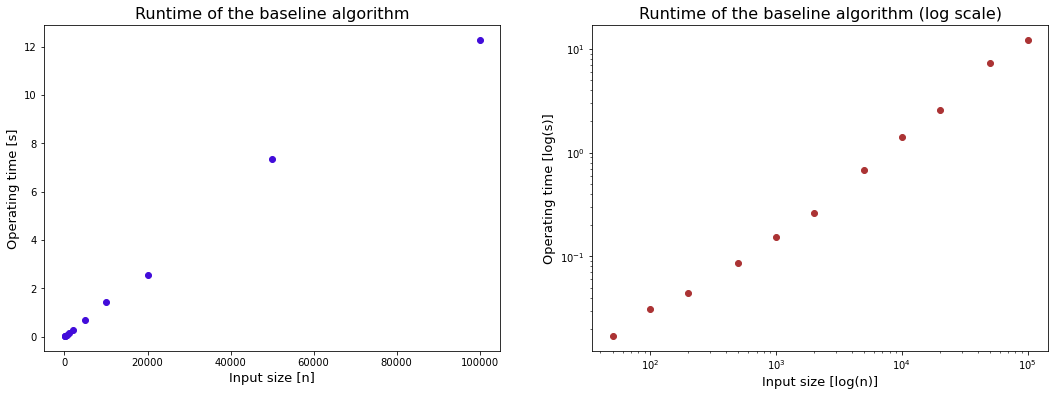

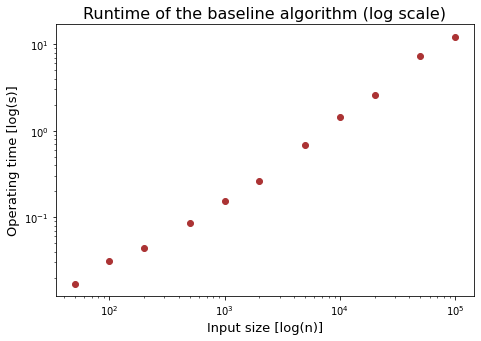

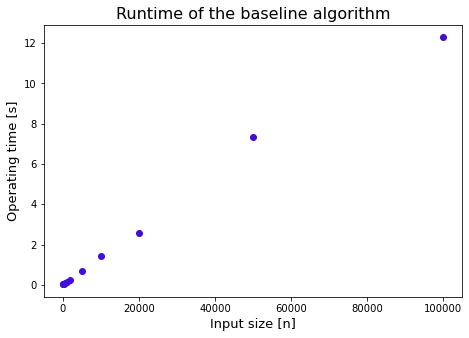

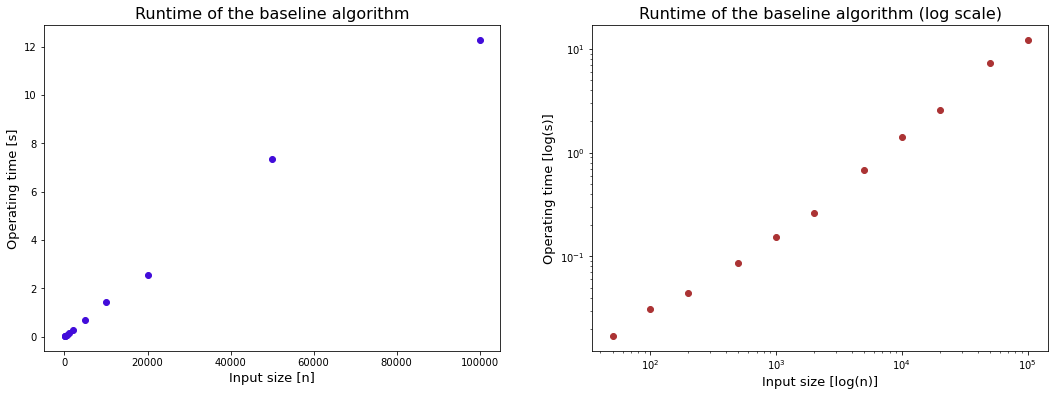

In [12]:
baseline_wow = plt.figure(figsize=(7.5, 5))
plt.scatter(x = baseline_limits, y=baseline_runtimes, color = '#AB3334')
plt.title('Runtime of the baseline algorithm (log scale)', fontsize = 16)
plt.ylabel('Operating time [log(s)]', fontsize = 13)
plt.xlabel('Input size [log(n)]', fontsize = 13)
plt.xscale("log")
plt.yscale('log')

baseline_wow2 = plt.figure(figsize=(7.5, 5))
plt.scatter(x = baseline_limits, y=baseline_runtimes, color = '#420CDA')
plt.title('Runtime of the baseline algorithm', fontsize = 16)
plt.ylabel('Operating time [s]', fontsize = 13)
plt.xlabel('Input size [n]', fontsize = 13)

baseline_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.scatter(x = baseline_limits, y=baseline_runtimes, color = '#420CDA')
ax1.set_title('Runtime of the baseline algorithm', fontsize = 16)
ax1.set_xlabel('Input size [n]', fontsize = 13)
ax1.set_ylabel('Operating time [s]', fontsize = 13)

ax2.scatter(x = baseline_limits, y=baseline_runtimes, color = '#AB3334')
ax2.set_title('Runtime of the baseline algorithm (log scale)', fontsize = 16)
ax2.set_ylabel('Operating time [log(s)]', fontsize = 13)
ax2.set_xlabel('Input size [log(n)]', fontsize = 13)
ax2.set_xscale("log")
ax2.set_yscale('log')

baseline_f

### Assessing the accuracy of predictions:

In [25]:
#Testing the Baseline

testingBaseline_df, testingBaseline_df_attr = load_data(BPI = 'Datasets/BPI_2012.csv', BPI_attr = 'Datasets/BPI_attr_2012.csv', data2012 = True)
testingBaseline_df = preprocessing(testingBaseline_df)

#Couldn't you re-use the data_split function here, Sven?
#Also, tqdm iterates exactly over 13087 rows here, why is it so? Won't this be incompatible with non-2012 data?


#amount of total data that is training data:
testingBaseline_train_data = 0.8
#amount of train data that is validation data:
testingBaseline_validation_data = 0.1

testingBaseline_limit_date = testingBaseline_df[testingBaseline_df['case_id'] == round(testingBaseline_df.iloc[-1, 0]*testingBaseline_train_data)].iloc[0]['time:timestamp']
#limit_date = datetime.datetime(2012, 2, 3, 1, 1, 1, 633000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))) 

#training data_set
testingBaseline_df_train = testingBaseline_df
testingBaseline_listo = []

for i in tqdm(range(0, 13087)):
    if testingBaseline_df[testingBaseline_df['case_id'] == i].iloc[-1]['time:timestamp'] > testingBaseline_limit_date:
        testingBaseline_listo.append(i)

for i in tqdm(range(0, len(testingBaseline_listo))):
    testingBaseline_df_train = testingBaseline_df_train.drop(testingBaseline_df_train[testingBaseline_df_train['case_id']==testingBaseline_listo[i]].index)

testingBaseline_df_train = testingBaseline_df_train.reset_index(drop = True)

#splitting training dataset into validation and training dataset
testingBaseline_mask = np.random.rand(len(testingBaseline_df_train)) < testingBaseline_validation_data
testingBaseline_df_validation = testingBaseline_df_train[testingBaseline_mask]
testingBaseline_df_train = testingBaseline_df_train[~testingBaseline_mask]

#testing data_set
testingBaseline_df_test = pd.DataFrame(columns = (testingBaseline_df.columns))
testingBaseline_listo = []

for i in tqdm(range(0, 13087)):
    if testingBaseline_df[testingBaseline_df['case_id'] == i].iloc[0]['time:timestamp'] > testingBaseline_limit_date:
        testingBaseline_listo.append(i)

for i in tqdm(range(0, len(testingBaseline_listo))):
    testingBaseline_df_test = testingBaseline_df_test.append(testingBaseline_df[testingBaseline_df['case_id'] == testingBaseline_listo[i]])

testingBaseline_df_test = testingBaseline_df_test.reset_index(drop = True)

testingBaseline_df_train.to_csv('BPI_2012_train', index=False)

testingBaseline_df_validation.to_csv('BPI_2012_validation')

testingBaseline_df_test.to_csv('BPI_2012_test', index=False)

KeyboardInterrupt: 

A simple function to print out some statistics of a model (?)

In [26]:
def timely_statistics(df_tree : pd.DataFrame, relative : bool, statistic : str) -> None:
    '''I automated the prints below ~ Rav
    possibly invoke with:
    for element in [(False, 'mean'), (False, 'median'), (True, 'mean'), (True, 'median')]:
        timely_statistics(df, relative=element[0], statistic=element[1])'''
    
    if(statistic == 'mean' and relative == False):
        seconds1, seconds2 = df_tree['time:absolute_prediction_off'].mean(), df_tree['time:absolute_prediction_correct'].mean()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('absolute off mean: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('absolute correct mean: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))
        
    if(statistic == 'median' and relative == False):
        seconds1, seconds2 = df_tree['time:absolute_prediction_off'].median(), df_tree['time:absolute_prediction_correct'].median()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('absolute off median: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('absolute correct median: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))
        
    if(statistic == 'mean' and relative==True):
        df_tree['time:absolute_prediction_off'].hist(bins=10)
        seconds1, seconds2 = df_tree['time:relative_prediction_off'].mean(), df_tree['time:relative_prediction_correct'].mean()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('relative off mean: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('relative correct mean: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))
        
    if(statistic == 'median' and relative==True):
        df_tree['time:absolute_prediction_off'].hist(bins=10)
        seconds1, seconds2 = df_tree['time:relative_prediction_off'].median(), df_tree['time:relative_prediction_correct'].median()
        minutes1, hours1, days1, minutes2, hours2, days2 = seconds1/60, seconds1/3600, seconds1/86400, seconds2/60, seconds2/3600, seconds2/86400
        print('relative off median: ' + str(seconds1) + ', ' + str(minutes1) + ', ' + str(hours1) + ', ' + str(days1))
        print('relative correct median: ' + str(seconds2) + ', ' + str(minutes2) + ', ' + str(hours2) + ', ' + str(days2))

absolute off mean: 119642.99285692869, 1994.0498809488115, 33.23416468248019, 1.384756861770008
absolute correct mean: 86030.3264827253, 1433.8387747120883, 23.897312911868138, 0.9957213713278391
absolute off median: 11690.880938999999, 194.84801564999998, 3.2474669274999997, 0.13531112197916664
absolute correct median: 0.899674, 0.014994566666666665, 0.00024990944444444445, 1.0412893518518517e-05
relative off mean: -56494.50100501799, -941.5750167502998, -15.69291694583833, -0.6538715394099305
relative correct mean: -48006.664901285025, -800.1110816880838, -13.335184694801395, -0.5556326956167248
relative off median: -4.701792, -0.07836320000000001, -0.0013060533333333333, -5.441888888888889e-05
relative correct median: 0.0, 0.0, 0.0, 0.0


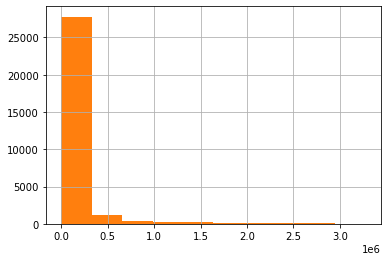

In [31]:
testingBaseline_df_train = pd.read_csv('BPI_2012_train')
testingBaseline_df_train['time:timestamp'] = testingBaseline_df_train['time:timestamp'].apply(fix_time)
testingBaseline_df_train['time:time_between'] = testingBaseline_df_train['time:timestamp'].diff()
testingBaseline_df_train.loc[testingBaseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

testingBaseline_df_test = pd.read_csv('BPI_2012_test')
testingBaseline_df_test['time:timestamp'] = testingBaseline_df_test['time:timestamp'].apply(fix_time)
testingBaseline_df_test['time:time_between'] = testingBaseline_df_test['time:timestamp'].diff()
testingBaseline_df_test.loc[testingBaseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

#creates column with predicted data
def prediction(prev):
    return baseline_all_expected_events[0][prev]

testingBaseline_df_test['predicted'] = testingBaseline_df_test['concept:name'].apply(prediction)

#function that creates the 'correct' using a dataframe, the predcting column and the true column, it shows wether the prediction was correct
testingBaseline_df_test['shifted_actual'] = testingBaseline_df_test['concept:name'].shift(-1)
testingBaseline_df_test['shifted_case_id'] = testingBaseline_df_test['case_id'].shift(-1)
    
def apply_function(var):
    if var[2] == var[3]:
        return (var[0] == var[1])
        
    else:
        return (var[0] == 'editor:close_case')
        
testingBaseline_df_test['correct'] = testingBaseline_df_test[['predicted', 'shifted_actual', 'case_id', 'shifted_case_id']].apply(apply_function, axis=1)
testingBaseline_df_test = testingBaseline_df_test.drop(['shifted_actual', 'shifted_case_id'], axis=1)

def prediction(prev):
    return baseline_all_expected_events[1][prev]

testingBaseline_df_test['time:between_predicted'] = testingBaseline_df_test['concept:name'].apply(prediction)

#create column with absolute difference between predicted time and actual time
def time_difference(var):
    return abs((var[0] - var[1]).total_seconds())

def time_difference_if_correct(var):
    if var[0]:
        return abs((var[1] - var[2]).total_seconds())
    else:
        return 0

testingBaseline_df_test['time:absolute_prediction_off'] = testingBaseline_df_test[['time:time_between', 'time:between_predicted']].apply(time_difference, axis=1)
testingBaseline_df_test['time:absolute_prediction_correct'] = testingBaseline_df_test[['correct', 'time:time_between', 'time:between_predicted']].apply(time_difference_if_correct, axis=1)

#create column with relative difference between predicted time and actual time
def time_difference(var):
    return (var[0] - var[1]).total_seconds()

def time_difference_if_correct(var):
    if var[0]:
        return (var[1] - var[2]).total_seconds()
    else:
        return 0

testingBaseline_df_test['time:relative_prediction_off'] = testingBaseline_df_test[['time:time_between', 'time:between_predicted']].apply(time_difference, axis=1)
testingBaseline_df_test['time:relative_prediction_correct'] = testingBaseline_df_test[['correct', 'time:time_between', 'time:between_predicted']].apply(time_difference_if_correct, axis=1)


#Changed the code below to this to clean up the notebook. For refernce/troubleshooting, below code is markdowned, not erased
for element in [(False, 'mean'), (False, 'median'), (True, 'mean'), (True, 'median')]:
    timely_statistics(testingBaseline_df_test, relative=element[0], statistic=element[1])

### Model

In [32]:
def prepare_dataframe_for_clustering(raw_df):
    df = raw_df.copy()
    
    #Prepare the time between columns
    df['time:timestamp'] = df['time:timestamp'].apply(fix_time)
    df["time:time_between"] = df["time:timestamp"].diff()
    df.loc[df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)
    df["time:time_between"] = [int(x.total_seconds()) for x in df["time:time_between"]]
    
    #Prepare the next event column
    df["next_event"] = df["concept:name"]
    df.loc[df['step_number'] == 0, 'next_event'] = 'editor: close_case'
    df["next_event"] = df["next_event"].shift(-1)
    df.loc[len(df) - 1, 'next_event'] = 'editor: close_case'
    
    return df

In [33]:
def prepare_column_for_clustering(case_id_column, cluster_column, unique_values):
    grouped_df = pd.DataFrame({'case_id': case_id_column, 'column': cluster_column})
    
    for val in unique_values:
        grouped_df[val] = 0
        grouped_df.loc[grouped_df['column'] == val, val] = 1
    
    return grouped_df[['case_id'] + list(unique_values)]

In [34]:
def get_clusters(prepared_rows):
    kmeans = KMeans(n_clusters=NR_OF_CLUSTERS)
    
    unique_columns = list(prepared_rows.columns)
    unique_columns.pop(0)

    df_grouped = prepared_rows.groupby('case_id')[unique_columns].sum()
    kmeans.fit(df_grouped[unique_columns])
    prediction = kmeans.labels_
    unique_case_ids = prepared_rows['case_id'].unique()
    return prepared_rows.case_id.map({unique_case_ids[i]: prediction[i] for i in range(len(prediction))}), kmeans

In [35]:
def get_tree(df_train, clusters, mapping):
    event_model = RandomForestClassifier(n_estimators=100, max_depth=10)
    time_model = RandomForestClassifier(n_estimators=100, max_depth=10)
    
    special_df = df_train.copy()
    
    special_df['next_event int'] = special_df['next_event'].map(mapping)
    
    X_dtc = special_df[clusters + ['step_number', 'time:weekday', 'time:hour', 'lifecycle:transition int']].copy()
    y_dtc = special_df[['next_event int', 'time:time_between']]

    event_model.fit(X_dtc, y_dtc['next_event int'])
    time_model.fit(X_dtc, y_dtc['time:time_between'])
    
    return event_model, time_model

In [36]:
def predict_clusters(cluster_model, prepared_rows, unique_columns):
    df_grouped = prepared_rows.groupby('case_id')[unique_columns].sum()
    prediction = cluster_model.predict(df_grouped[unique_columns])
    unique_case_ids = prepared_rows['case_id'].unique()
    return prepared_rows.case_id.map({unique_case_ids[i]: prediction[i] for i in range(len(prediction))})

In [37]:
def predict_value(tree, df_predict, clusters):
    X_dtc = df_predict[clusters + ['step_number', 'time:weekday', 'time:hour', 'lifecycle:transition int']]
    
    prediction = tree.predict(X_dtc)
    return prediction

In [38]:
def cluster_tree_predict(df_train, df_test):
    cluster_tree_train, cluster_tree_test = prepare_dataframe_for_clustering(df_train), prepare_dataframe_for_clustering(df_test)
    
    le = pre.LabelEncoder()
    le.fit(cluster_tree_train['lifecycle:transition'].unique())
    cluster_tree_train['lifecycle:transition int'] = le.transform(cluster_tree_train['lifecycle:transition'])
    cluster_tree_test['lifecycle:transition int'] = le.transform(cluster_tree_test['lifecycle:transition'])
    
    mapping, reverse_mapping = {}, {}
    all_events = ['editor: close_case'] + list(cluster_tree_train['concept:name'].unique())    

    for i in range(len(all_events)):
        mapping[all_events[i]] = i
        reverse_mapping[i] = all_events[i]
    
    #Clustering
    cluster_columns = ['concept:name'] # ENTER CLUSTER COLUMN NAMES (max 2) HERE
    assigned_columns = [cluster_columns[i] + ' cluster' for i in range(len(cluster_columns))]
    
    for i in range(len(cluster_columns)):
        #Make sure no NaN values exist in these columns
        cluster_tree_train[cluster_columns[i]] = cluster_tree_train[cluster_columns[i]].fillna(-1)
        cluster_tree_test[cluster_columns[i]] = cluster_tree_test[cluster_columns[i]].fillna(-1)
        
        unique_values = cluster_tree_train[cluster_columns[i]].unique()
        prepared_train_data = prepare_column_for_clustering(cluster_tree_train['case_id'], cluster_tree_train[cluster_columns[i]], unique_values)
        cluster_tree_train[assigned_columns[i]], cluster_model = get_clusters(prepared_train_data)

        prepared_test_data = prepare_column_for_clustering(cluster_tree_test['case_id'], cluster_tree_test[cluster_columns[i]], unique_values)
        cluster_tree_test[assigned_columns[i]] = predict_clusters(cluster_model, prepared_test_data, unique_values)
        
    
    for i in tqdm(range(NR_OF_CLUSTERS)):
        next_amount = NR_OF_CLUSTERS
        if len(cluster_columns) == 1:
            next_amount = 1
        for j in range(next_amount):
            if len(cluster_columns) == 1:
                clustered_train_df = cluster_tree_train[cluster_tree_train[assigned_columns[0]] == i]
                clustered_test_df = cluster_tree_test[cluster_tree_test[assigned_columns[0]] == i]
            else:
                clustered_train_df = cluster_tree_train[(cluster_tree_train[assigned_columns[0]] == i) & (cluster_tree_test[assigned_columns[1]] == j)]
                clustered_test_df = cluster_tree_test[(cluster_tree_test[assigned_columns[0]] == i) & (cluster_tree_test[assigned_columns[1]] == j)]
        
            if clustered_train_df.size > 0:
                event_model, time_model = get_tree(clustered_train_df, assigned_columns, mapping)
        
                if clustered_test_df.size > 0:
                    if len(cluster_columns) == 1:
                        cluster_tree_test.loc[cluster_tree_test[assigned_columns[0]] == i, 'prediction'] = np.vectorize(reverse_mapping.get)(predict_value(event_model, clustered_test_df, assigned_columns))
                        cluster_tree_test.loc[cluster_tree_test[assigned_columns[0]] == i, 'time:between_predicted'] = predict_value(time_model, clustered_test_df, assigned_columns)
                    else:
                        cluster_tree_test.loc[(cluster_tree_test[assigned_columns[0]] == i) & (cluster_tree_test[assigned_columns[1]] == j), 'prediction'] = np.vectorize(reverse_mapping.get)(predict_value(event_model, clustered_test_df, assigned_columns))
                        cluster_tree_test.loc[(cluster_tree_test[assigned_columns[0]] == i) & (cluster_tree_test[assigned_columns[1]] == j), 'time:between_predicted'] = predict_value(time_model, clustered_test_df, assigned_columns)
    
    return cluster_tree_test
    
#use df_train for the train, df_validation for testing the parameters and df_test for testing the final result.

### Model testing using test data

In [39]:
NR_OF_CLUSTERS = 14

In [42]:
#I used tree as a standin for the df_test result, this can be changed later
df_tree = cluster_tree_predict(df_train, df_test)
df_tree

KeyboardInterrupt: 

In [ ]:
#prints accuracy of the tree dataset
accuracy = round((len(df_tree[df_tree['next_event'] == df_tree['prediction']])/len(df_tree))*100, 1)
print('accuracy: ' + str(accuracy) + '%')

In [ ]:
#shows which predictions are given too much (>1) and which too little (<1)
predicted_correct_events = Counter(list(df_tree[df_tree['next_event'] == df_tree['prediction']]['prediction']))
predicted_events = Counter(list(df_tree['prediction']))
true_events = Counter(list(df_tree['next_event']))

for i in predicted_events:
    if i != i:
        break
    print(i)
    per = round(predicted_events[i]/true_events[i]*100, 1)
    print(str(per) + '%')
    if per > 100:
        print('given ' + str(round(per-100, 1)) + '% too much')
    
    elif per < 100:
        print('given ' + str(round(100-per, 1)) + '% too little')
    
    else:
        print('given exactly the right amount')
   
    print('')

In [ ]:
df_tree

In [ ]:
#shows time related attributes of tree (assuming that time is stored in 'time:between_predicted')
#create column with absolute difference between predicted time and actual time
def time_difference_if_correct(var):
    if var[0]:
        return abs((var[1] - var[2]))
    else:
        return (0)
    
def apply_function(var):
    if var[2] == var[3]:
        return (var[0] == var[1])
        
    else:
        return (var[0] == 'editor:close_case')
        
df_tree['shifted_case_id'] = df_tree['case_id'].shift(-1)
df_tree.loc[len(df_tree) - 1, 'shifted_case_id'] = 0
df_tree['correct'] = df_tree[['prediction', 'next_event', 'case_id', 'shifted_case_id']].apply(apply_function, axis=1)
df_tree = df_tree.drop(['shifted_case_id'], axis=1)

df_tree['time:relative_prediction_off'] = df_tree['time:time_between'] - df_tree['time:between_predicted']
df_tree['time:absolute_prediction_off'] = df_tree['time:relative_prediction_off'].abs()

df_tree['time:relative_prediction_correct'] = df_tree['time:time_between'] - df_tree['time:between_predicted']
df_tree['time:absolute_prediction_correct'] = df_tree['time:relative_prediction_correct'].abs()    

        
for element in [(True, 'mean'), (True, 'median'), (False, 'mean'), (False, 'median')]:
    timely_statistics(df_tree, relative=element[0], statistic=element[1])

### Visualizations

In [ ]:
from sklearn.decomposition import PCA
from random import randint
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
#Group pre-cluster df by case (case_id)
precluster_df = prepare_column_for_clustering(df['case_id'], df['concept:name'], df['concept:name'].unique())
precluster_df_by_case = precluster_df.groupby('case_id').sum()
precluster_df_by_case.head()

In [ ]:
#Perform PCA (2 component) on the data
pca2d = PCA(n_components = 2)
pca2d.fit(precluster_df_by_case)

In [ ]:
#Perform PCA (3 component) on the data
pca3d = PCA(n_components = 3)
pca3d.fit(precluster_df_by_case)

In [ ]:
#Create 2d dataframe
pca2d_df = pd.DataFrame(pca2d.transform(precluster_df_by_case))
pca2d_df.index.names = ['case_id']
pca2d_df.head()

In [ ]:
#Create 3d dataframe
pca3d_df = pd.DataFrame(pca3d.transform(precluster_df_by_case))
pca3d_df.index.names = ['case_id']
pca3d_df.head()

In [ ]:
#Retrieve Clusters
df['concept:name cluster'], cluster_model = get_clusters(precluster_df)

In [ ]:
#Group regular df by case (case_id)
df_by_case = df.groupby('case_id').mean()[['concept:name cluster']]
df_by_case.head()

In [ ]:
#Merge the dataframes for 2d
vis2d_df = pd.merge(df_by_case, pca2d_df, on='case_id', how='left')
vis2d_df.columns = ['cluster', 'x_comp', 'y_comp']
vis2d_df.head()

In [ ]:
#Merge the dataframes for 3d
vis3d_df = pd.merge(df_by_case, pca3d_df, on='case_id', how='left')
vis3d_df.columns = ['cluster', 'x_comp', 'y_comp', 'z_comp']
vis3d_df.head()

In [ ]:
#Plot with low alpha
sns.lmplot('x_comp', 'y_comp', data=vis2d_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.25});

In [ ]:
#Plot with high alpha
sns.lmplot('x_comp', 'y_comp', data=vis2d_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.9});

In [ ]:
def random_colorscale(n):
    lst = []
    scale = 0
    initial = ['red','green','blue','orange','yellow','purple','black','pink','cyan','magenta']
    for i in range(n):
        if i < len(initial):
            color = initial[i]
        else:
            color = "#" + "%06x" % randint(0, 0xFFFFFF)
        lst.append((round(scale, 2), color))
        scale += 1/(n-1)
        
    
    return lst
#[(0, "red"), (0.14, "yellow"), (0.29, "purple"), (0.43, "green"), (0.57, "blue"), (0.71, "black"), (0.86, "orange"), (1, "pink")]
random_colorscale(4)
random_colorscale(NR_OF_CLUSTERS)

In [ ]:
lst = [(0, "red"), (0.14, "yellow"), (0.29, "purple"), (0.43, "green"), (0.57, "blue"), (0.71, "black"), (0.86, "orange"), (1, "pink")]
fig = go.Figure(data=[go.Scatter3d(
    x=vis3d_df['x_comp'],
    y=vis3d_df['y_comp'],
    z=vis3d_df['z_comp'],
    mode='markers',
    marker=dict(
        size=4,
        color=vis3d_df['cluster'],
        colorscale=random_colorscale(14),
        opacity=0.5
    )
)])
fig.show()